In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam


In [2]:
DATA_DIR = './data/CamVid'

if not os.path.exists(DATA_DIR):
    print("loading data...")
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print("Done!")

In [3]:
class CamVidDataset:
    
    CLASSES = ['sky', 'building', 'pole', 'road',
              'pavement', 'tree', 'signsymbol', 'fence',
              'car', 'pedestrian', 'bicyclist', 'unlabeled']
    
    def __init__(
        self,
        images_dir,
        masks_dir,
        classes = CLASSES,
        preprocessing = None
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis = -1).astype('float')

        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis = -1, keepdims = True)
            mask = np.concatenate((mask, background), axis = -1)

        if self.preprocessing:
            sample = self.preprocessing(image = image, mask = mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)



In [4]:
X_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

X_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

X_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [5]:
train_dataset = CamVidDataset(X_train_dir, y_train_dir)
print(len(train_dataset))
image, mask = train_dataset[5]
print(image.shape)
print(mask.shape)

367
(360, 480, 3)
(360, 480, 13)


In [6]:
CLASSES = ['sky', 'building', 'road', 'tree', 'car', 'pedestrian']

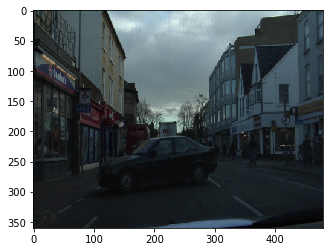

In [7]:
train_dataset = CamVidDataset(X_train_dir, y_train_dir, classes = CLASSES)
image, mask = train_dataset[50]
plt.imshow(image)

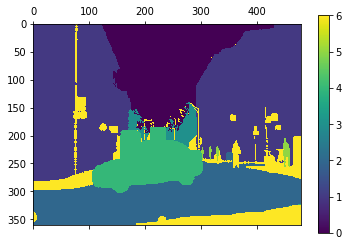

0 sky
1 building
2 road
3 tree
4 car
5 pedestrian


In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
color_ax = ax.matshow(np.argmax(mask, axis = -1))
fig.colorbar(color_ax)
plt.show()

for i, class_ in enumerate(CLASSES):
    print(i, class_)

In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = "he_normal",
              padding = "same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = "he_normal",
              padding = "same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


In [10]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(n_filters*1, (1, 1), activation='softmax') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:
INPUT_HEIGHT = 352
INPUT_WIDTH = 480
N_CHANNELS = 3
input_img = keras.Input((INPUT_HEIGHT,INPUT_WIDTH,N_CHANNELS), name = 'img')
model = get_unet(input_img, n_filters = len(CLASSES) + 1, dropout = 0.05, batchnorm = True)
model.compile(optimizer=Adam(), loss = 'binary_crossentropy', metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 352, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 480, 7)  196         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 352, 480, 7)  28          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 352, 480, 7)  0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [14]:
def crop_image(height, width, image):
    cropped_image = image[:height, :width, :]
    return cropped_image

In [15]:
class CamVidDataGenerator(keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=32, dim=(352,480), n_channels=3,
                n_classes=7, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __getitem__(self, index):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)

        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]

        for i, ID in enumerate(indexes):
            image, mask = self.dataset[ID]
            X[i,] = crop_image(*self.dim, image)
            y[i,] = crop_image(*self.dim, mask)

        return X, y
    
    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


        

In [16]:
train_dataset = CamVidDataset(
    X_train_dir,
    y_train_dir,
    classes = CLASSES
)

valid_dataset = CamVidDataset(
    X_valid_dir,
    y_valid_dir,
    classes = CLASSES
)

BATCH_SIZE = 8
params = {'batch_size': BATCH_SIZE,
         'dim': (INPUT_HEIGHT, INPUT_WIDTH),
         'n_channels': N_CHANNELS,
         'n_classes': len(CLASSES)+1,
         'shuffle': True}

training_generator = CamVidDataGenerator(train_dataset, **params)
validation_generator = CamVidDataGenerator(valid_dataset, **params)


In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCHS = 5

history = model.fit_generator(generator=training_generator,
                             validation_data = validation_generator,
                             epochs=EPOCHS,
                             callbacks = [ModelCheckpoint(filepath='./ckpt.hdf5',
                                                         monitor='val_accuracy',
                                                         save_best_only=True,
                                                         verbose=1),
                                         EarlyStopping(monitor='val_accuracy',
                                                      patience=10,
                                                      verbose=1)])

Epoch 1/5
44/45 [============================>.] - ETA: 8s - loss: 0.1690 - accuracy: 0.9390 
Epoch 00001: val_accuracy improved from -inf to 0.92028, saving model to ./ckpt.hdf5
45/45 [==============================] - 407s 9s/step - loss: 0.1692 - accuracy: 0.9389 - val_loss: 0.2192 - val_accuracy: 0.9203
Epoch 2/5
44/45 [============================>.] - ETA: 8s - loss: 0.1564 - accuracy: 0.9439 
Epoch 00002: val_accuracy did not improve from 0.92028
45/45 [==============================] - 394s 9s/step - loss: 0.1559 - accuracy: 0.9440 - val_loss: 0.2116 - val_accuracy: 0.9197
Epoch 3/5
44/45 [============================>.] - ETA: 8s - loss: 0.1524 - accuracy: 0.9438 
Epoch 00003: val_accuracy improved from 0.92028 to 0.92849, saving model to ./ckpt.hdf5
45/45 [==============================] - 401s 9s/step - loss: 0.1525 - accuracy: 0.9438 - val_loss: 0.1898 - val_accuracy: 0.9285
Epoch 4/5
44/45 [============================>.] - ETA: 8s - loss: 0.1419 - accuracy: 0.9476 
Epoch 

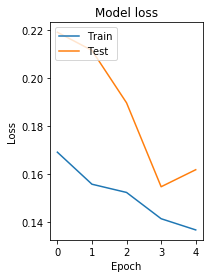

In [29]:
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [30]:
test_dataset = CamVidDataset(
    X_test_dir,
    y_test_dir,
    classes = CLASSES
)

Image:  0


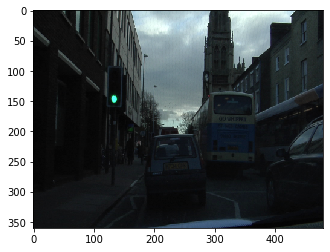

Ground truth mask: 


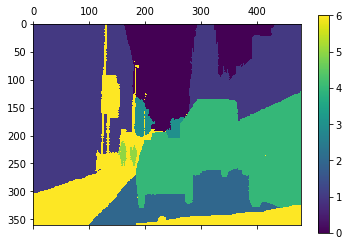

Predicted mask: 


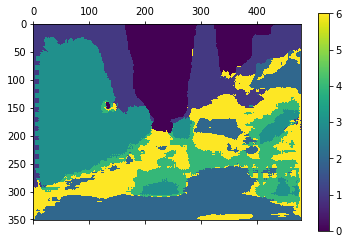

Image:  16


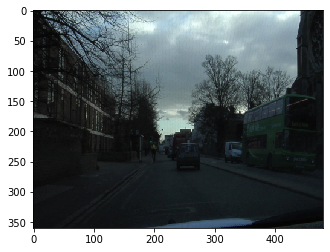

Ground truth mask: 


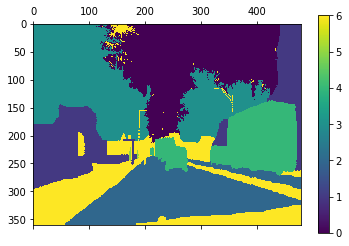

Predicted mask: 


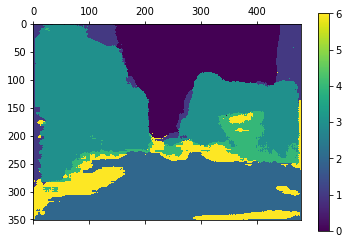

Image:  122


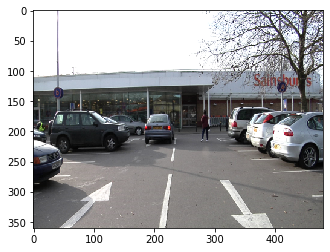

Ground truth mask: 


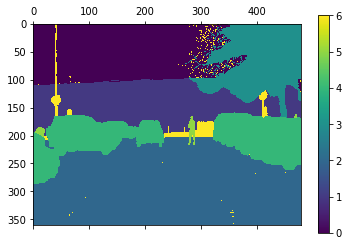

Predicted mask: 


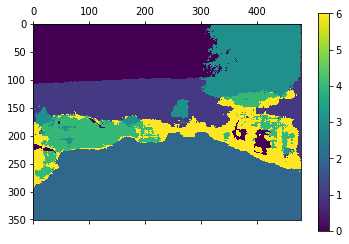

Image:  87


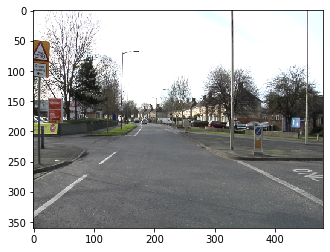

Ground truth mask: 


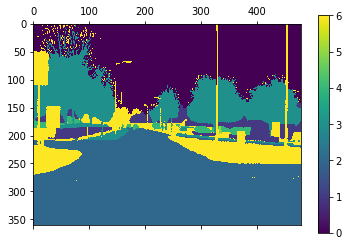

Predicted mask: 


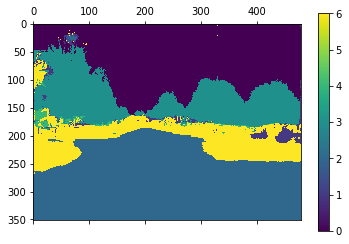

Image:  42


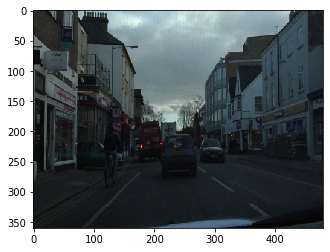

Ground truth mask: 


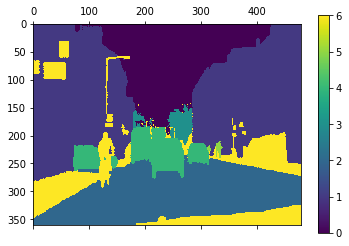

Predicted mask: 


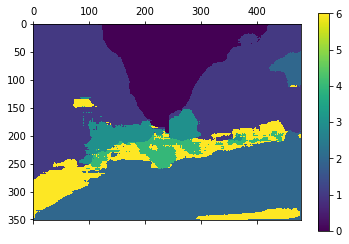

Image:  57


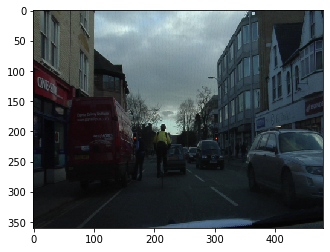

Ground truth mask: 


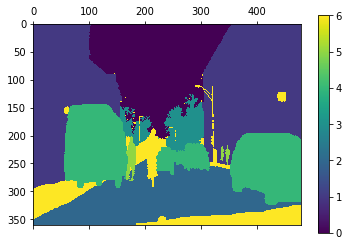

Predicted mask: 


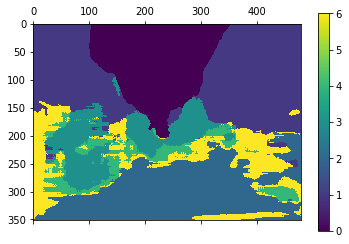

Image:  146


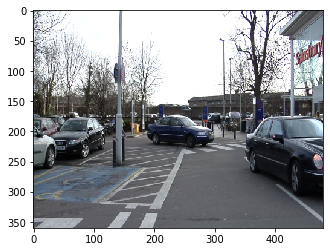

Ground truth mask: 


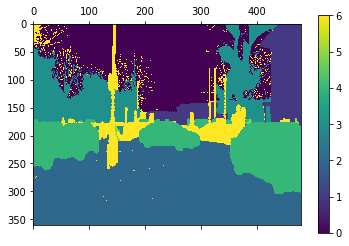

Predicted mask: 


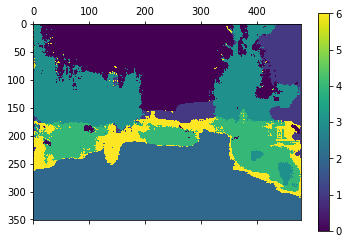

Image:  107


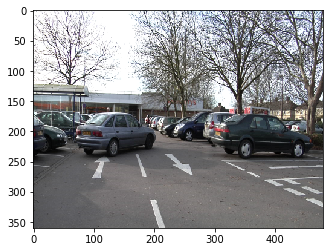

Ground truth mask: 


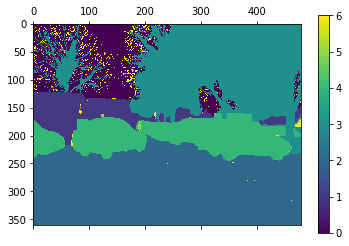

Predicted mask: 


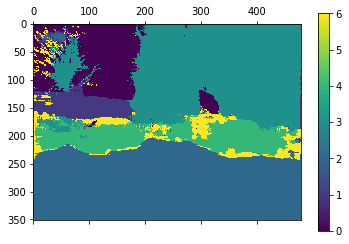

Image:  8


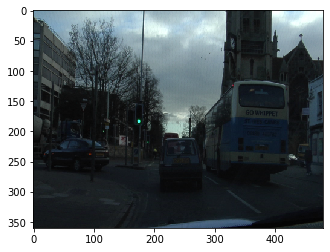

Ground truth mask: 


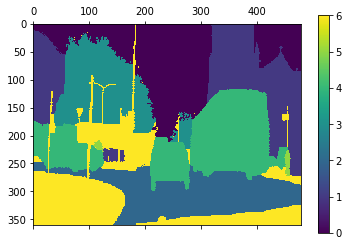

Predicted mask: 


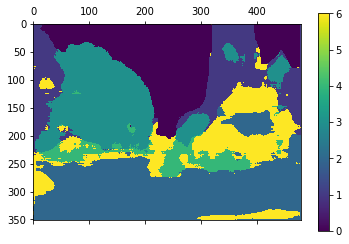

Image:  159


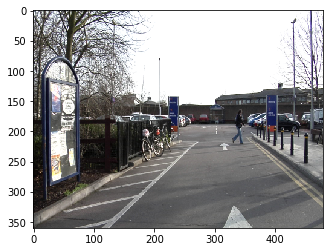

Ground truth mask: 


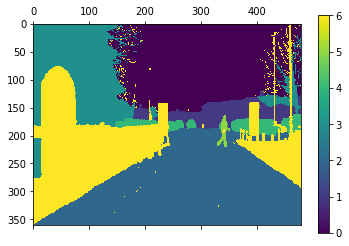

Predicted mask: 


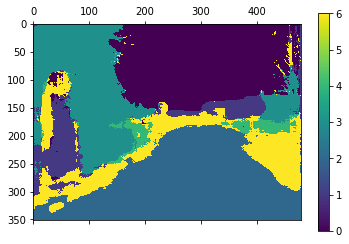

0 sky
1 building
2 road
3 tree
4 car
5 pedestrian


In [44]:
ids = [0,16,122,87,42,57,146,107,8,159]

for i in ids:
    image, gt_mask = train_dataset[i]
    
    cropped_image = crop_image(INPUT_HEIGHT, INPUT_WIDTH, image)
    image_array = np.expand_dims(cropped_image, axis = 0).astype('float')
    pr_mask = model.predict(image_array)
    
    print("Image: ", i)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image)
    plt.show()
    
    print("Ground truth mask: ")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cropped_gt_mask = crop_image(INPUT_HEIGHT, INPUT_WIDTH, gt_mask)
    color_ax = ax.matshow(np.argmax(gt_mask, axis = -1))
    fig.colorbar(color_ax)
    plt.show()
    
    print("Predicted mask: ")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    color_ax = ax.matshow(np.argmax(pr_mask.squeeze(), axis = -1))
    fig.colorbar(color_ax)
    plt.show()
    
for i, class_ in enumerate(CLASSES):
    print(i, class_)


In [45]:
#model.save_weights('Bens_weights.h5')

In [46]:
model.load_weights('Bens_weights.h5')

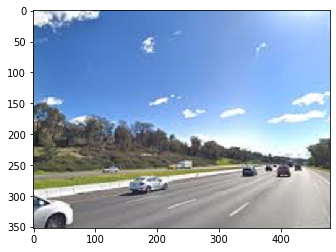

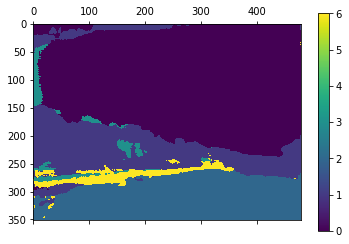

0 sky
1 building
2 road
3 tree
4 car
5 pedestrian


In [43]:
image = cv2.imread("camvid-9.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

cropped_image = crop_image(INPUT_HEIGHT, INPUT_WIDTH, image)
image_array = np.expand_dims(cropped_image, axis=0).astype('float')
pr_mask = model.predict(image_array)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(cropped_image)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
color_ax = ax.matshow(np.argmax(pr_mask.squeeze(), axis = -1))
fig.colorbar(color_ax)
plt.show()

for i, class_ in enumerate(CLASSES):
    print(i, class_)
